In [1]:
'''
Library that allows us to easily load MNIST data.
Note it's only because MNIST is so popular that
there is a library to do this. Typically data
must be loaded manually.
'''
import mnist

#Load training images and labels
training_images = mnist.train_images()
training_labels = mnist.train_labels()

In [2]:
#Load numpy for basic manipulations
import numpy as np
#Matplotlib.pyplot to display plots
import matplotlib.pyplot as plt

print("Training Images Dimensions ",np.shape(training_images))
print("Training Labels Dimensions ",np.shape(training_labels))
print()

print(f"Example Data point ({training_labels[0]})")
plt.imshow(training_images[0],cmap='gray')
plt.show()

Training Images Dimensions  (60000, 28, 28)
Training Labels Dimensions  (60000,)

Example Data point (5)


<Figure size 640x480 with 1 Axes>

In [3]:
'''
Function that converts numerical representation
to a one hot representation.  That is if there
are n different classes, class k will be represented
by a vector of length n with all zeros except for a
single 1 at index k.
'''
def one_hot(labels,num_classes):
    return [[int(i==l) for i in range(num_classes)] for l in labels]

#Convert training labels to one hot
one_hot_training_labels = one_hot(labels=training_labels,num_classes=10)

#Flatten image to allow for input in to feed forward network
flat_training_images = np.reshape(training_images,[-1,784])

print(f"{training_labels[0]} -> {one_hot_training_labels[0]}")
print(f"{np.shape(training_labels)} -> {np.shape(one_hot_training_labels)}")
print(f"{np.shape(training_images)} -> {np.shape(flat_training_images)}")

5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
(60000,) -> (60000, 10)
(60000, 28, 28) -> (60000, 784)


In [16]:
#one_hot_training_labels
#flat_training_images.shape

In [17]:
#Load test images and labels
test_images = mnist.test_images()
test_labels = mnist.test_labels()

#Flatten images and convert labels to one hot
flat_test_images = np.reshape(test_images,[-1,784])
one_hot_test_labels = one_hot(test_labels,10)

In [18]:
'''
Here we use an optimized sklearn logistic regression
implementation to gauge how well or neural network
performs later
'''
from sklearn.linear_model import LogisticRegression

'''
Multinomial indicates that we have multiple classes,
that is our output is not a single number 0 to 1 but
a probability distribution between the different classes.
More on how this works later.  'Saga' is an optimizer
capable of solving multinomial regression.  Typically
results are greatly diminishing after the first couple
iterations.  max_iter=10 is to prevent the fitting
process from taking excessively long.
'''
model = LogisticRegression(solver='saga',max_iter=10,multi_class='multinomial')
print("Training...")
model.fit(flat_training_images,training_labels)
print("Complete.")
lr_weight_mat = model.coef_
lr_bias = model.intercept_

Training...
Complete.


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [31]:
print(lr_weight_mat.shape)
#print(lr_weight_mat[0])
print(lr_weight_mat)
print(lr_bias)


(10, 784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[-3.92422399e-05  3.33302547e-05  3.46033815e-05 -4.61259175e-05
  7.02256118e-06  2.25295124e-04 -1.68758399e-05  7.20259623e-05
 -2.23991899e-04 -4.60413867e-05]


In [19]:
print("Optimal Logistic Regression scores")
print("Accuracy on Training Data: ",model.score(flat_training_images,training_labels))
print("Accuracy on Test Data: ",model.score(flat_test_images,test_labels))

Optimal Logistic Regression scores
Accuracy on Training Data:  0.93215
Accuracy on Test Data:  0.9263


In [20]:
#Load tensorflow for neural networks
import tensorflow as tf

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
'''
MODE=0 creates a network that has no hidden layers
directly mapping from input to output.

MODE=1 creates a feed forward neural network 
with 2 hidden layers.
'''
MODE = 1

#Placeholder for image data (# of images x pixel values)
x = tf.placeholder(tf.float32,shape=[None,784])
#Placeholder for labels (# of images x # of classes)
y = tf.placeholder(tf.float32,shape=[None,10])

if(MODE==0):
    #Singly fully connected layer to output
    USE_LR = True
    if(not USE_LR):
        initial_weight = tf.truncated_normal([784,10],stddev=0.1)
        initial_bias = tf.constant(0.0,shape=[10])
    else:
        initial_weight = lr_weight_mat.T.astype('float32')
        initial_bias = lr_bias.astype('float32')
    weight_mat = tf.Variable(initial_weight)
    bias = tf.Variable(initial_bias)
    out = tf.matmul(x,weight_mat)+bias

In [11]:
'''
These functions return parameters for our network.
These are variables that can modified during the training process.
These functions also serve to provide the necessary initial values.
'''
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0,shape=shape)
    return tf.Variable(initial)

'''
This method returns the outputs resulting from a fully connected layer.
inp contains the activations of the previous layer.
inp_dim: # of neurons in input layer, out_dim: # of neurons in this layer.
'''
def fully_connected(inp,inp_dim,out_dim,activation=None):
    weight_matrix = weight_variable([inp_dim,out_dim])
    bias = bias_variable([out_dim])
    raw = tf.matmul(inp,weight_matrix)+bias
    if(activation):
        return activation(raw)
    else:
        return raw

In [12]:
if(MODE==1):
    #1st hidden layer has 100 neurons
    h1 = fully_connected(inp=x,inp_dim=784,out_dim=100,activation=tf.nn.relu)
    #2nd hidden layer has 50 neurons
    h2 = fully_connected(inp=h1,inp_dim=100,out_dim=50,activation=tf.nn.relu)
    #Final layer maps to output 10 neurons for 10 classes
    out= fully_connected(inp=h2,inp_dim=50,out_dim=10)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
#Cross entropy loss applied after using softmax activation
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=out))

[-1, 0, 1, 2] -> [0.032, 0.087, 0.237, 0.644]
[-3, 3, 3] -> [0.001, 0.499, 0.499]


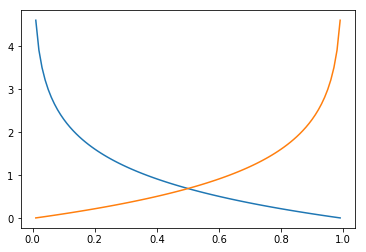

Cross Entropy Loss (Blue T=1) (Orange T=0)


In [14]:
'''
Understanding 'softmax_cross_entropy_with_logits_v2'
Softmax function takes a vector of inputs and maps
it to a probability distribution.  Note this is also
what is used in multinomial logistic regression!
'''
def softmax(v):
    all_pos = np.exp(v)
    normalized = all_pos/sum(all_pos)
    return [round(i,3) for i in normalized]

ex_1 = [-1,0,1,2]
ex_2 = [-3,3,3]
print(f"{ex_1} -> {softmax(ex_1)}")
print(f"{ex_2} -> {softmax(ex_2)}")

#Visualization of cross entropy loss
spec = np.arange(start=0.01,stop=1,step=0.01)
plt.plot(spec,-np.log(spec))
plt.plot(spec,-np.log(1-spec))
plt.show()
print("Cross Entropy Loss (Blue T=1) (Orange T=0)")

In [15]:
'''
Adam optimizer performs gradient descent while
also performing learning rate adaptation and
handling class imbalance.  Note the latter
is not a concern with MNIST.
'''
train_step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

'''
The network's prediction is the class it offers
the highest probability and its accuracy is
computed accordingly.
'''
correct_prediction = tf.equal(tf.argmax(out,axis=1),tf.argmax(y,axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [16]:
'''Initializing session and parameters'''
#Initialize tensorflow session
sess = tf.InteractiveSession()
#Parameters assigned initial values
sess.run(tf.global_variables_initializer())

Training Loss: 97.0  Accuracy: 0.0612
Validation Loss: 97.3  Accuracy: 0.0587
Epoch  1
Batch 5000
Training Loss: 0.762  Accuracy: 0.825
Validation Loss: 0.696  Accuracy: 0.835
Epoch  2
Batch 5000
Training Loss: 0.343  Accuracy: 0.909
Validation Loss: 0.356  Accuracy: 0.91
Epoch  3
Batch 5000
Training Loss: 0.225  Accuracy: 0.937
Validation Loss: 0.261  Accuracy: 0.93
Epoch  4
Batch 5000
Training Loss: 0.168  Accuracy: 0.951
Validation Loss: 0.222  Accuracy: 0.942
Epoch  5
Batch 5000
Training Loss: 0.134  Accuracy: 0.959
Validation Loss: 0.198  Accuracy: 0.947
Epoch  6
Batch 5000
Training Loss: 0.114  Accuracy: 0.966
Validation Loss: 0.191  Accuracy: 0.951
Epoch  7
Batch 5000
Training Loss: 0.0918  Accuracy: 0.972
Validation Loss: 0.178  Accuracy: 0.956
Epoch  8
Batch 5000
Training Loss: 0.0788  Accuracy: 0.976
Validation Loss: 0.181  Accuracy: 0.958
Epoch  9
Batch 5000
Training Loss: 0.0669  Accuracy: 0.978
Validation Loss: 0.176  Accuracy: 0.959
Epoch  10
Batch 5000
Training Loss: 0.0

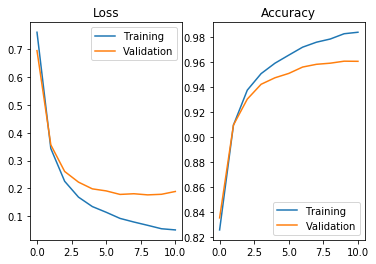

In [17]:
'''TRAINING'''

#Separating 10000 validation images from training set
training_data, val_data = flat_training_images[:50000],flat_training_images[50000:]
t_labels, v_labels = one_hot_training_labels[:50000],one_hot_training_labels[50000:]

#Maximum number of epochs to run
EPOCHS = 25
#Number of images to consider at once while training
batch_size = 10
num_batches = len(training_data)//batch_size

#Keep track of loss and accuracy for graphing
performance = {'t_l':[],'t_a':[],'v_l':[],'v_a':[]}

'''
Evaluate loss and accuracy on training and validation 
sets.  Additionally append metrics to performance tracker.
'''
def eval_performance():
    l,a = sess.run([loss,accuracy],feed_dict={x:training_data,y:t_labels})
    performance['t_l'].append(l)
    performance['t_a'].append(a)
    print(f"Training Loss: {l:.3}  Accuracy: {a:.3}")
    l,a = sess.run([loss,accuracy],feed_dict={x:val_data,y:v_labels})
    performance['v_l'].append(l)
    performance['v_a'].append(a)
    print(f"Validation Loss: {l:.3}  Accuracy: {a:.3}")

for e in range(EPOCHS):
    #Before beginning the epoch evaluate performance
    eval_performance()
    '''
    Early stopping.  When validation performance significantly drops
    we know the model is overfitting.  Note the training loss will
    likely continue to go down.
    '''
    if(len(performance['v_l'])>2 and performance['v_l'][-1]>performance['v_l'][-3]):
        EPOCHS = e+1
        break
    print("Epoch ",e+1)
    #Pass through the whole training dataset once
    for b in range(num_batches):
        print(f"Batch {b+1}",end = '\r')
        images = flat_training_images[b*batch_size:(b+1)*batch_size]
        labels = one_hot_training_labels[b*batch_size:(b+1)*batch_size]
        sess.run(train_step,feed_dict={x:images,y:labels})
    print()

'''    
Plot loss for training and validation sets over the
epochs.  Note the first item is left out in both of
these as prior to any training, loss will be wildly
high and accuracy will be very low.  Doing this
allows us to zoom in on the interesting part.
'''
plt.subplot(121)
plt.title("Loss")
plt.plot(range(EPOCHS-1),performance['t_l'][1:])
plt.plot(range(EPOCHS-1),performance['v_l'][1:])
plt.legend(['Training','Validation'])

plt.subplot(122)
plt.title("Accuracy")
plt.plot(range(EPOCHS-1),performance['t_a'][1:])
plt.plot(range(EPOCHS-1),performance['v_a'][1:])
plt.legend(['Training','Validation'])

plt.show()

In [18]:
print("Final Test Accuracy:")
print(sess.run(accuracy,feed_dict={x:flat_test_images,y:one_hot_test_labels}))

Final Test Accuracy:
0.9557


In [19]:
'''
Note: State of the art MNIST is about 99.8% on test data.
Granted they used a number of complex tricks to perform
this level of optimization.  But the the key difference
between what we did here and the best models is something
we'll get to later in this course.
'''
print("Done!")

Done!
